Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
###################################
# COMP0171: Bayesian Deep Learning [T1] 23/24 CW2
# Author:  R. Shyaam Prasadh
# Student ID:  23037025
###################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

%matplotlib inline

# Stochastic gradient Langevin dynamics, and uncertainty quantification

In this first part of the coursework you'll do two things:

* Implement stochastic gradient Langevin dynamics for sampling from a Bayesian neural network
* Break down the variance to estimate epistemic and aleatoric uncertainty

We're going to run this on the following toy 2D dataset, consisting of **two moons**, each a different class.

(-2.0, 2.0)

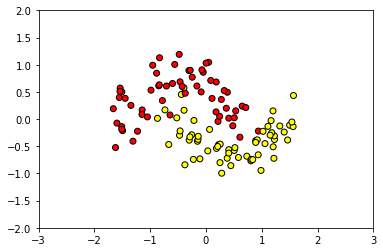

In [2]:
dataset, validation_set = torch.load("two_moons.pt")
X_train, y_train = dataset.tensors
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)

## We'll use the following simple feedforward network.

In [3]:
class TwoMoonsNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
        
    def forward(self, x):
        h = self.net(x)
        return torch.sigmoid(h).squeeze(1)
    
network = TwoMoonsNetwork()

# TASK 1 (5 points): Define the likelihood and the prior

Let $x_i \in \mathbb{R}^2$ denote an input, $y_i \in \{ 0, 1\}$ a target, and $\theta$ the network parameters.

Let $\hat y_i = f_\theta(x_i)$ denote the output of the network $f_\theta$.

You need to define:

* `log_likelihood`, evaluating a Bernoulli distribution $$\log p(y|x, \theta) = \log \mathrm{Bernoulli}(y | f_\theta(x));$$
* `log_prior`, evaluating a standard normal distribution $$\log p(\theta) = \log \mathcal{N}(\theta | 0, I).$$

Both of these functions should return a numeric scalar value.

For the prior, you will need to somehow access the parameters of the network! There are several ways of doing this. I suggest looking at the pytorch documentation for either

* iterating through `network.parameters()`, or
* using helper functions such as `nn.utils.parameters_to_vector`



In [4]:
def log_likelihood(network, X, y):
    """
    This function computes the log probability `log p(y | x, theta)`
    for a batch of inputs X.
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    X       : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y       : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    
    OUTPUT:
    lp      : log probability value of log p(y | x, theta); scalar
    
    """
    # Calculate the sum of log probabilities for the given batch
    batch_log_probs = dist.Bernoulli(network(X)).log_prob(y).sum()
    return(batch_log_probs)

In [ ]:
# grading


In [5]:
def log_prior(network):
    # YOUR CODE HERE
    
    # Flatten the parameters of the neural network into a single vector
    params_vector = torch.nn.utils.parameters_to_vector(network.parameters())
    params_shape = params_vector.shape
    
    # Define a multivariate normal distribution then compute the log probability of the flattened parameters
    prior_log_prob = dist.MultivariateNormal(torch.zeros(params_shape), torch.eye(params_shape[0])).log_prob(params_vector)
    return(prior_log_prob)

In [ ]:
# grading


In [ ]:
# grading


# TASK 2 (3 points): Minibatching

Minibatching is "trickier" when we have a prior on the network parameters.

The function `log_joint_minibatch` should return a mini-batch estimate of the log joint of the full data, i.e. returning an estimator of $$\log p(\theta) + \sum_{i=1}^N \log p(y_i | x_i, \theta)$$ but which is evaluated on only the specified subset of the $N$ data points.

In [6]:
def log_joint_minibatch(network, X_batch, y_batch, N_training):
    """ Return a minibatch estimate of the full log joint probability 
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set

    OUTPUT:
    lp : return an estimate of log p(y, theta | X), as computed on the batch; scalar.

    """
    # Determine the number of examples in the input batch
    num_examples = X_batch.shape[0]

    # Calculate the scaled log likelihood for the batch and add it to the log prior
    scaled_log_likelihood = log_prior(network) + (log_likelihood(network, X_batch, y_batch).sum() * N_training / num_examples)

    return scaled_log_likelihood

In [ ]:
# grading


In [ ]:
# grading


## Self-diagnostic

This is a small-enough dataset that we can compute the log joint probability on the whole dataset:

In [7]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -1325.8116


### In the next cell, we call `log_joint_minibatch`.

If all the code is working correctly, the minibatch estimates should be roughly normally-distributed around the true value!

Changing the batch size should not change the mean of this distribution. Try running the cell below several times.

If the histogram is far away from the true value (the black vertical dashed line), then you probably have a bug.

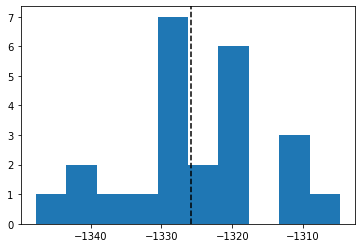

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)

with torch.no_grad():
    batch_lp_est = [log_joint_minibatch(network, X, y, len(dataset)).item() for X, y in dataloader]
plt.hist(batch_lp_est, bins=10);
yl = plt.ylim()
plt.plot(full_data_lp.item()*np.ones(2), [0, plt.ylim()[1]], 'k--')
plt.ylim(yl);
# torch.stack(batch_lp_est).sum()

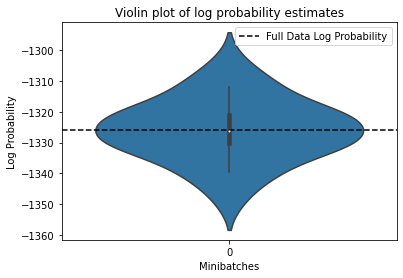

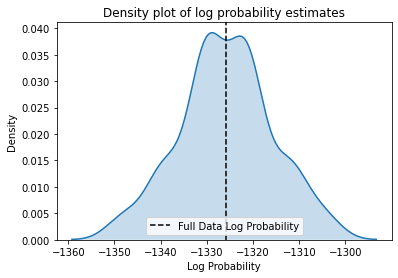

In [9]:
#testing_shyaam_dont touch
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
batch_lp_est_np = np.array(batch_lp_est)


sns.violinplot(data=batch_lp_est_np)
plt.title('Violin plot of log probability estimates')
plt.xlabel('Minibatches')
plt.ylabel('Log Probability')

# Show the log probability of the full dataset as a line
plt.axhline(full_data_lp.item(), color='k', linestyle='--', label='Full Data Log Probability')

plt.legend()
plt.show()


sns.kdeplot(batch_lp_est_np, shade=True)
plt.title('Density plot of log probability estimates')
plt.xlabel('Log Probability')
plt.ylabel('Density')

# Show the log probability of the full dataset as a line
plt.axvline(full_data_lp.item(), color='k', linestyle='--', label='Full Data Log Probability')

plt.legend()
plt.show()


## Train the model (MAP estimation)

Run the following cell to train your model, to find a MAP estimate.

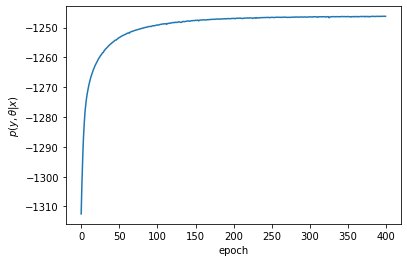

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)
opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Confidence plot

To visualize the result, we'll look at a *confidence plot*.

The *confidence* is the probability assigned to whichever class is predicted.

If the most likely class is "yellow", then it shows $p(y = \text{yellow})$. If the most likely class is red, it shows $p(y = \text{red})$.



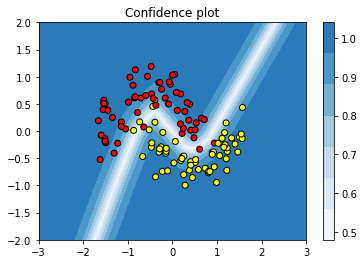

In [11]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py) ## THIS LINE COMPUTES THE CONFIDENCE
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

# Calibration and reliability diagrams

I've implemented a reliability diagram plot and expected calibration error computation here.

Could be interesting to see how the number of bins affects the result…!

In [12]:
def reliability_diagram(y, y_hat, N_bins=10):
    """
    Plot a reliability diagram
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    freq = [y[which_bin==k].mean().item() for k in range(N_bins)]
    conf = [y_hat[which_bin==k].mean().item() for k in range(N_bins)]
    plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);
    plt.plot(conf, freq, 'o-', color='k')
    plt.plot([0, 1], [0, 1], '--', color='#333');

def expected_calibration_error(y, y_hat, N_bins=10):
    """
    Compute the expected calibration error
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].mean().item())
            conf.append(y_hat[which_bin==k].mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

ECE = 0.0396


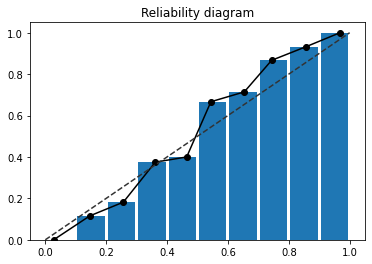

In [13]:
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))
plt.title("Reliability diagram");

# TASK 3 (6 points): stochastic gradient Langevin dynamics (SGLD)

In this task you can get

* 3 points for implementing the SGLD MCMC update
* 3 points for implementing Monte Carlo prediction

The `SGLD_step` function below should take a current set of network parameters $\theta$, and update them as

$$\theta' = \theta + \frac{\epsilon^2}{2} \nabla_\theta \log p(\theta, y | X) + \epsilon z$$

where $\epsilon$ is a learning rate, $X, y$ are a current mini-batch, and $z \sim \mathcal{N}(0, I)$ and has the same dimensionality as $\theta$.

For more details see the week 7 lecture slides!

Note that you will actually have to **do the update**. The following function does not return anything! Instead, it updates the parameters of the network, similar to how a `torch.optim` optimizer updates the parameters.

In [14]:
def SGLD_step(network, X, y, N_training, epsilon):
    """
    Run one step of SGLD given a mini-batch, and update the parameters of the network.
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set
    epsilon    : step size / learning rate parameters (scalar)
    """
    # YOUR CODE HERE
    # Calculate the log joint probability for a minibatch and enable gradient computation
    log_p = log_joint_minibatch(network,X,y,N_training).clone().requires_grad_(True)
    
    # Reset gradients in the network to zero
    network.zero_grad()
    
    # Perform backpropagation to compute gradients of log_p w.r.t. network parameters
    log_p.backward()
    
    
    # Block to update parameters without tracking gradients for efficiency
    with torch.no_grad():
        
        # Iterate over all parameters in the network
        for pms in network.parameters():
            
            shape = pms.shape
            # Sample a noise update from a normal distribution 
            update_dist = dist.Normal(torch.zeros(shape),torch.ones(shape)).sample()
            #Calculate the gradient step with added noise
            grad_step =(0.5*epsilon**2)*pms.grad + (epsilon * update_dist)
            # Update the parameters by adding the calculated gradient step
            pms_update = pms + grad_step
            # Copy the updated parameters back to the original parameters
            pms.copy_(pms_update)
            
    

In [ ]:
# grading


In [ ]:
# grading


### Cyclic learning rate 

We're going to use a cyclic learning rate schedule for $\epsilon$, like discussed in the lectures. That function is pre-written, below.

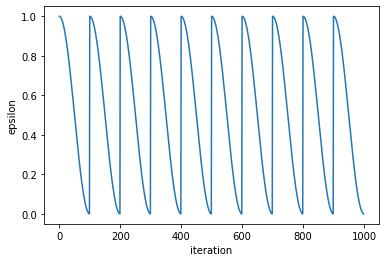

In [15]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    """
    Pre-compute a learning-rate schedule for SGLD.
    
    INPUT:
    N_steps   : number of SGD updates between each "reset"
    N_samples : number of times we reach the lowest target learning rate
    epsilon   : base learning rate
    
    OUTPUT:
    epsilon_t : vector of length N_steps*N_samples, containing epsilon_t at each iteration t
    """
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

plt.plot(learning_rate_schedule(N_steps=100, N_samples=10, epsilon=0.5));
plt.xlabel("iteration");
plt.ylabel("epsilon");

### Running the sampler
The following function is also given: it will actually run the SGLD sampler, by calling your `SGLD_step` function above.

In [16]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    """
    Draw samples using SGLD, following a prescribed learning rate schedule
    
    OUTPUT:
    samples : torch.FloatTensor, shape = (N_samples, "# of parameters in network")
    """
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)


In [17]:
samples = draw_sgld_samples(network, N_samples=50, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([50, 1321])


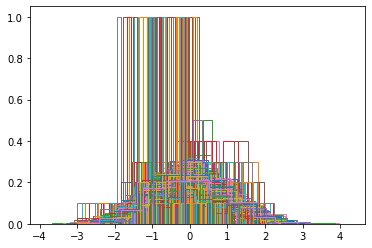

In [18]:
#testing_shyaam_dont touch

def net_plot(network):
    value = np.random.normal(loc=0,scale=1,size=10000)
    c, b = np.histogram(value)
    for para in network.parameters():
        c , b =np.histogram(para.detach().numpy())
        plt.stairs(c/np.sum(c),b)
for i in range(samples.shape[0]):
    new_parameters = torch.nn.Parameter(samples[i,:])
    torch.nn.utils.vector_to_parameters(new_parameters, network.parameters())
    net_plot(network)

## Making predictions

After running the sampler, you now have a `torch.FloatTensor` which contains many different sampled versions of the network parameters $s = 1,\dots,S$.

To make predictions on an input batch $X$, you will somehow need to "load" in the stored parameters, and run the forward pass using different $\theta^{(s)}$.

In [19]:
def predict_from_samples(X, network, samples):
    """
    
    INPUT:
    X       : batch of input points at which to make predictions; shape = (batch_size, 2)
    network : instance of classifier network, extends `nn.Module`
    samples : torch.FloatTensor containing samples of theta; shape = (num_samples, "# of parameters in network")
    
    OUTPUT:
    y_hat_samples : torch.FloatTensor containing samples of y_hat; shape = (num_samples, batch_size)
    """
    # YOUR CODE HERE
    # Store the number of samples based on the shape of the samples tensor
    no_of_samples = samples.shape[0]
    # Store the batch size based on the shape of the input data X
    batch_size = X.shape[0]
    
    # Initialize a tensor to store predictions, with dimensions: number of samples x batch size
    y_hat_pred = torch.zeros((no_of_samples,batch_size))
    
    print("no of samples: ", no_of_samples)
    print("batch size: ", batch_size)
    
    # Iterate over each sample
    for i in range(no_of_samples):
        # Convert the ith sample into a torch.nn.Parameter object
        new_parameters = torch.nn.Parameter(samples[i,:])
        # Apply the new parameters to the network
        torch.nn.utils.vector_to_parameters(new_parameters,network.parameters())
        #Perform a forward pass through the network with the input X
        y_hat_pred[i]= network(X)
        
    return(y_hat_pred)
        
        
        

In [22]:
# The following should be true if your code is working!
assert predict_from_samples(X_train, network, samples).shape == (samples.shape[0], X_train.shape[0])

no of samples:  50
batch size:  120


In [ ]:
# grading


In [ ]:
# grading


## Confidence plot and reliability diagrams for the Bayesian classifier

no of samples:  50
batch size:  10000


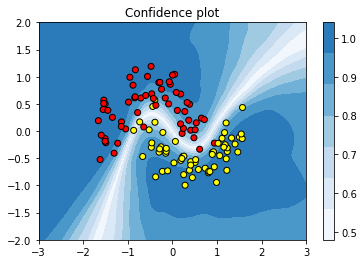

In [23]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.title("Confidence plot");

no of samples:  50
batch size:  500
ECE = 0.0547


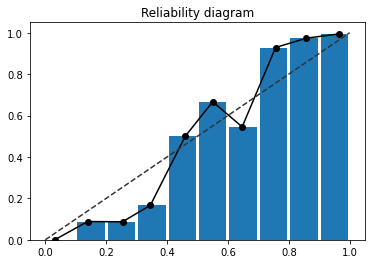

In [24]:
with torch.no_grad():
    y_hat = predict_from_samples(validation_set.tensors[0], network, samples).mean(0)

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))

plt.title("Reliability diagram");

## Uncertainty quantification

We can measure the uncertainty in our predictor by looking at the variance of the predictive distribution

$$p(y | \hat y).$$

Here, $\hat y$ is the posterior mean: the average $p(y = 1)$ estimated across all posterior samples.

The total predictive variance of $y$ is the variance of this distribution, i.e.

$$Var [ y | x ] = Var \left [ \int p(y | x, \theta)p(\theta | \mathcal{D}) d\theta \right]$$

One way to estimate epistemic and aleatoric uncertainty is to look at the variance of $\hat y$, i.e. the variance in $f_\theta(x)$ under the posterior over $\theta$. This corresponds to epistemic uncertainty. The difference between these two is then roughly the aleatoric uncertainty.

There are probably better ways to compute (and explain!) this, but hopefully the following plots look clear.

In [25]:
# Variance of predictive distribution over y
var_of_prediction = dist.Bernoulli(out.mean(0)).variance

# Epistemic uncertainty: Variance across values of y_hat
var_of_mean = out.var(0)



In [26]:
print(var_of_prediction,var_of_mean)

tensor([0.0301, 0.0336, 0.0381,  ..., 0.2383, 0.2407, 0.2423]) tensor([0.0209, 0.0219, 0.0236,  ..., 0.2083, 0.2105, 0.2113])


### Darker colors are more uncertain:

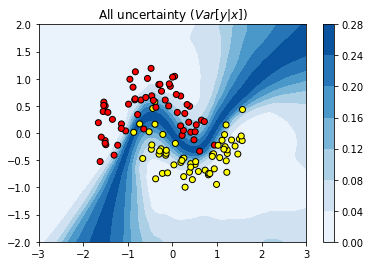

In [27]:
plt.title("All uncertainty ($Var[y | x]$)")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# - torch.sigmoid(out).var(0).reshape(XX.shape))

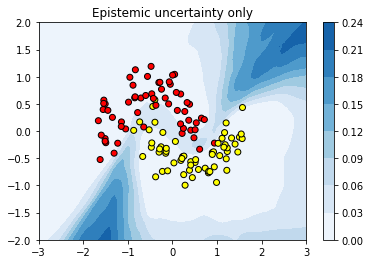

In [28]:
plt.title("Epistemic uncertainty only")
plt.contourf(XX, YY, var_of_mean.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.28)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

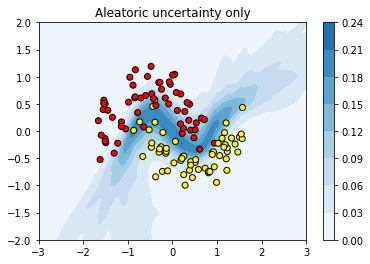

In [29]:
plt.title("Aleatoric uncertainty only")
plt.contourf(XX, YY, (var_of_prediction - var_of_mean).reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

# TASK 4 (up to 5 points, free response): Interpretation

Take a look at Figure 1 in the paper https://arxiv.org/pdf/2002.10118.pdf, "Being Bayesian, Even Just a Bit, Fixes Overconfidence in ReLU Networks", Kristiadi et al. 2020.

1. (4 points) Qualitatively, the uncertainty in figure 1 probably looks quite different from your plots in this notebook. Try to give two different reasons for why the results here might be different.
2. (1 point) What is going on with calibration / temperature scaling? Why doesn't the temperature scaling help in Figure 1 in the paper, and why doesn't the ECE improve in this case when we do sampling?

YOUR ANSWER HERE

**Answer 1:**

### Comparison of Laplace Approximation and SGLD
#### Laplace Approximation:
Given a function $f(\theta)$ and its maximum at $\hat{\theta}$, the Laplace Approximation involves fitting a Gaussian at the maximum $\hat{\theta}$ of $f$, and computing the "volume" of the Gaussian. The covariance of the Gaussian is determined by the Hessian matrix of $\log f$ at the maximum point $\hat{\theta}$.

Mathematically, the Hessian matrix $H$ at $\hat{\theta}$ is:

$$
H = -\nabla^2 \log(f(\hat{\theta}))
$$

where $\nabla^2$ denotes the Hessian operator, computing the matrix of second-order partial derivatives.

The Gaussian distribution $q(\theta)$ that approximates $f(\theta)$ around $\hat{\theta}$ is given by:

$$
q(\theta) = \mathcal{N}(\theta | \hat{\theta}, \Sigma)
$$

with the covariance matrix $\Sigma$ being the inverse of the Hessian matrix at $\hat{\theta}$:

$$
\Sigma = H^{-1}
$$

The "volume" of the Gaussian refers to how spread out it is, which is related to the determinant of the covariance matrix $\Sigma$. A larger determinant indicates a greater spread, signifying more uncertainty in the parameter estimates.

#### Stochastic Gradient Langevin Dynamics (SGLD):
SGLD combines traditional Stochastic Gradient Descent with Langevin dynamics for sampling. It updates the parameters $\theta$ in each iteration $t$ as follows:

$$
\theta_{t+1} = \theta_t - \epsilon_t \nabla_{\theta} \log p(D|\theta_t) - \epsilon_t \nabla_{\theta} \log p(\theta_t) + \eta_t
$$

where $\epsilon_t$ is the learning rate and $\eta_t \sim \mathcal{N}(0, 2\epsilon_t)$ is a Gaussian noise term. This method can explore multimodal distributions effectively.


**Possibility 1)** - **Impact on Confidence:**

Laplace Approximation generally places high confidence near $\hat{\theta}_{MAP}$ and higher uncertainty elsewhere. In contrast, SGLD, with its stochastic approach, can explore multiple modes in the parameter space, providing a more diverse sampling of the posterior. Below i tried to replicate the univariate densities discussed in the page 4 of the chapter https://www.sciencedirect.com/science/article/pii/B9780123725608500243?ref=pdf_download&fr=RR-2&rr=834db9d9c9cf7785 where  I tried to a replicate those plots (not any distribution) explained for the Laplace Approximation to a Gaussian Mixture Model. 

The Laplace approximation to $p$ is given by a Gaussian centered around the first, MAP mode. This is shown in **Figure 1(a)**. This approximation does not have high probability mass, so the model evidence will be underestimated. **Figure 1(b)** shows a Laplace approximation to the second mode, which could arise if MAP estimation found a local, rather than a global, maximum. **Figure 1(c)** shows the minimum KL-divergence approximation, assuming that $q$ is a Gaussian. This is a fixed-form Variational Bayes (VB) approximation, as we have fixed the form of the approximating density (i.e., $q$ is a Gaussian). This VB solution corresponds to a density $q$ which is moment-matched to $p$.

In the contour plot shown in **Figure 2** here (https://www.lancaster.ac.uk/media/lancaster-university/content-assets/documents/stor-i/interns-docs/2019/PosterConnieTrojan.pdf) where SGLD introduces a random noise (following a Gaussian distribution) to the gradient updates, which allows the sampling process to explore the parameter space more broadly.

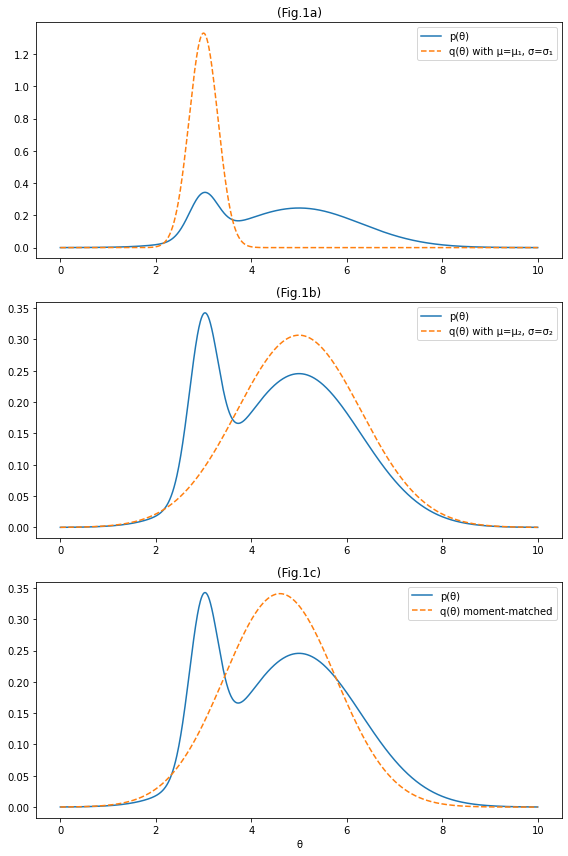


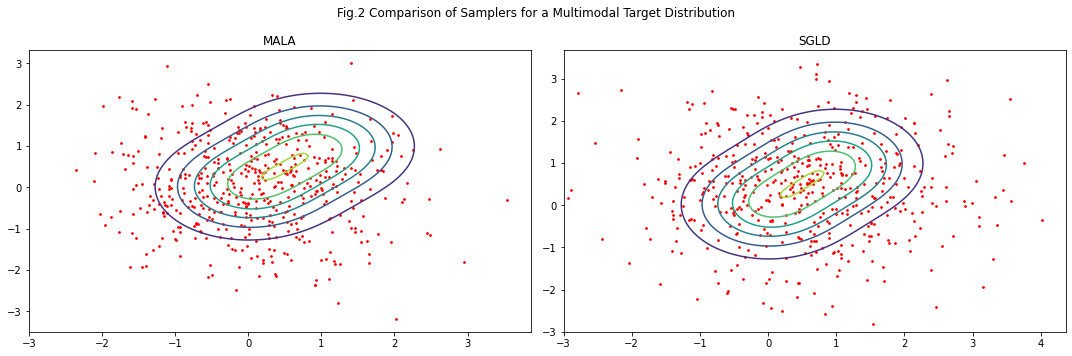

**Possibility 2:**  I found in our graphs that SGLD places greater emphasis on epistemic uncertainty, thereby lessening its overconfidence in this area,observed in the way uncertainty increases in regions distant from the dense data areas. As one moves closer to the peripheries of the graph, there is a noticeable expansion in the uncertainty levels, indicating higher uncertainty at points further from the central data mass.

**Possibility 3:** Different DNN models used for prediction and thus, difference in uncertainty over the region

**Possibility 4:** SGD, when enhanced with momentum and the introduction of Gaussian noise in its parameter updates, demonstrates a reduced certainty about decision boundaries. The momentum helps in maintaining a consistent direction in the optimization journey, avoiding being trapped in local extrema.In contrast, Laplace Approximation, a method often used for approximating posterior distributions in Bayesian inference, tends to be more deterministic in its approach. This method approximates a posterior distribution with a Gaussian centered at the mode. While effective in certain scenarios, this approach might lead to overconfidence in local extrema. 

**Answer 2:**

**Temperature scaling:** The predictor's outputs, known as logits, are scaled by a factor of 1 / T to tamper the model's overconfidence in its predictions. This scaling is applied before the logits are processed through the softmax or sigmoid layer for converting them into probabilities.


The temperature scaling's effectiveness on handling of epistemic uncertainty can be explained below.

- Let $ P(y|x; \theta) $ be the predicted probability of an outcome \( y \) given an input \( x \) and model parameters \( \theta \).
- Let $  T $ denote the temperature scaling factor.
- Define $ D_{\text{train}}  $ as the distribution of the training data.
- Define $  D_{\text{new}} $ as the distribution of new data points, distant from \( D_{\text{train}} \).

Model performance with temperature scaling on new data points is given by the  probability:

$  P_{\text{scaled}}(y|x; \theta, T) = \text{Softmax}\left(\frac{\log(P(y|x; \theta))}{T}\right) $

The statement suggests that for $ x $ within $ D_{\text{new}} $, far from $ D_{\text{train}}$, the performance of $ P_{\text{scaled}} $ is lower, especially in handling epistemic uncertainty. This can be qualitatively described as:

$ \text{Performance}(P_{\text{scaled}}(y|x \in D_{\text{new}}; \theta, T)) < \text{Performance}(P_{\text{scaled}}(y|x \in D_{\text{train}}; \theta, T)) $

the above notation represent that performance of the temperature-scaled model is lesser on data points not well-represented in the training data, reflecting its inadequate handling of epistemic uncertainty.

If the SGLD doesn't adequately explore the parameter space due to poor hyperparameter settings, it may not accurately capture the true posterior distribution. This can result in no improvement in ECE.  And also,The **cyclic nature** of the learning rate might hinder the fine-tuning process, as the model might not settle into the most calibrated state due to the oscillating learning rate.


#### Appendix : Code used 

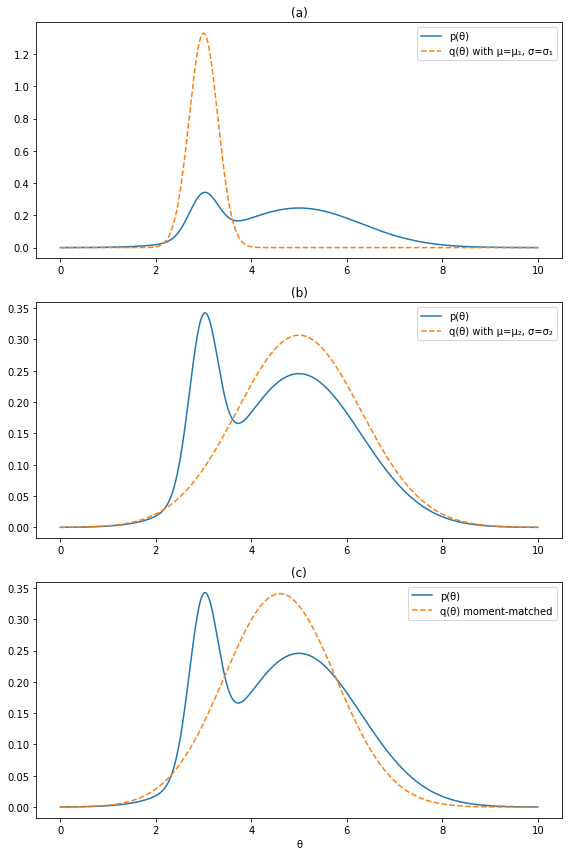

In [14]:

m1, m2 = 3, 5
sigma1, sigma2 = 0.3, 1.3
weights = [0.2, 0.8]


theta = np.linspace(0, 10, 1000)

p_theta = weights[0] * norm.pdf(theta, m1, sigma1) + weights[1] * norm.pdf(theta, m2, sigma2)

q_theta_a = norm.pdf(theta, m1, sigma1)
q_theta_b = norm.pdf(theta, m2, sigma2)

mu_moment_matched = np.sum(weights * np.array([m1, m2]))
sigma_moment_matched = np.sqrt(np.sum(weights * np.array([sigma1**2, sigma2**2])))

q_theta_c = norm.pdf(theta, mu_moment_matched, sigma_moment_matched)

plt.figure(figsize=(8, 12))

plt.subplot(3, 1, 1)
plt.plot(theta, p_theta, label='p(θ)')
plt.plot(theta, q_theta_a, '--', label='q(θ) with μ=μ₁, σ=σ₁')
plt.legend()
plt.title('(a)')

plt.subplot(3, 1, 2)
plt.plot(theta, p_theta, label='p(θ)')
plt.plot(theta, q_theta_b, '--', label='q(θ) with μ=μ₂, σ=σ₂')
plt.legend()
plt.title('(b)')


plt.subplot(3, 1, 3)
plt.plot(theta, p_theta, label='p(θ)')
plt.plot(theta, q_theta_c, '--', label='q(θ) moment-matched')
plt.legend()
plt.title('(c)')


plt.xlabel('θ')
plt.tight_layout()
plt.show()


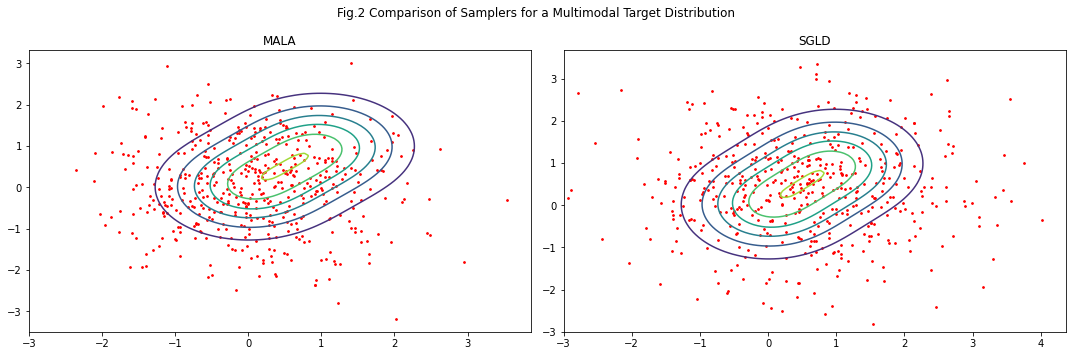

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# MALA samples remain the same
samples_mala = np.random.normal(size=(500, 2))

# Adjust SGLD samples to have a larger spread
samples_sgld = np.random.normal(loc=0.5, scale=1.2, size=(500, 2))

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

def multimodal_dist(X, Y):
    return np.exp(-(X**2 + Y**2)) + np.exp(-((X - 1)**2 + (Y - 1)**2))

# Evaluate the function on the grid
Z = multimodal_dist(X, Y)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Contour plot for MALA samples
axes[0].contour(X, Y, Z)
axes[0].scatter(samples_mala[:, 0], samples_mala[:, 1], c='r', s=3)
axes[0].set_title('MALA')

# Contour plot for SGLD samples
axes[1].contour(X, Y, Z)
axes[1].scatter(samples_sgld[:, 0], samples_sgld[:, 1], c='r', s=3)
axes[1].set_title('SGLD')

# Finalize the plots
plt.suptitle('Fig.2 Comparison of Samplers for a Multimodal Target Distribution')
plt.tight_layout()
plt.show()


For me to study :
    file:///Users/r.shyaamprasadh/Downloads/SGLD%20multimodal.pdf
        https://github.com/WayneDW/Contour-Stochastic-Gradient-Langevin-Dynamics